In [ ]:
!pip install accelerate -U
!pip install datasets
!pip install evaluate

In [2]:
# Carregando bibliotecas

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

In [3]:
# Programando funções úteis

def txt2df(livroSeparado, autor, separacao = 30):

  tempDict = {"texto":[]}


  for indice in range(0, len(livroSeparado), separacao):
    tempDict["texto"].append(" ".join(livroSeparado[indice:indice+separacao]))

  tempDict["autor"] = [autor]*len(tempDict["texto"])

  tempDf = pd.DataFrame.from_dict(tempDict)

  return(tempDf)

def juntarDf(listaDataframes):

  resultado = pd.concat(listaDataframes)

  return resultado

In [4]:
livros = [
    ("/content/drive/MyDrive/Machine Learning/TransferLearningEscritores/Alencar/A alma de lazaro.txt", "Alencar"),
    ("/content/drive/MyDrive/Machine Learning/TransferLearningEscritores/Alencar/A pata da gazela.txt", "Alencar"),
    ("/content/drive/MyDrive/Machine Learning/TransferLearningEscritores/Alencar/A viuvinha.txt", "Alencar"),
    ("/content/drive/MyDrive/Machine Learning/TransferLearningEscritores/Machado/casaVelha.txt", "Machado"),
    ("/content/drive/MyDrive/Machine Learning/TransferLearningEscritores/Machado/domCasmurro.txt", "Machado"),
    ("/content/drive/MyDrive/Machine Learning/TransferLearningEscritores/Machado/helena.txt", "Machado"),

]

autores = {
    "Alencar": 0,
    "Machado": 1
}

listaDataframes = []

for caminho, autor in livros:
  with open(f'{caminho}') as file:
    livro = file.read()
    livroSeparado = livro.split("\n")
    listaDataframes.append(txt2df(livroSeparado, autores[autor]))

df = juntarDf(listaDataframes)
print(df)


                                                 texto  autor
0    A ALMA DO LÁZARO José de Alencar Alfarrábios A...      0
1    Era eu estudante na academia de Olinda. Tinha ...      0
2    informe da cidade recortando o seu perfil no a...      0
3    São Francisco, recordavam a resistência heróic...      0
4    reflexões profundas que despertava essa evocaç...      0
..                                                 ...    ...
182  — Deixe-me morrer! murmurou ela. — Não! bradou...      1
183  porque ele aceitava sem murmúrio os decretos d...      1
184  manhã. Voltaram à alcova da enferma. Esta fech...      1
185  reflexo da eternidade parecia dar-lhe um encan...      1
186                                                         1

[634 rows x 2 columns]


In [5]:
df['autor'].value_counts()

1    450
0    184
Name: autor, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df['texto'], df['autor'], random_state=42)

In [7]:
y_train.value_counts()

1    341
0    134
Name: autor, dtype: int64

In [8]:
X_train_array = np.array(X_train).reshape(-1, 1)
X_test_array = np.array(X_test).reshape(-1, 1)

In [9]:
# Balancear o dataset já que tem muito mais dado de Machado do que Alencar

under_sampler = RandomUnderSampler(random_state=42)
X_train_balanceado, y_train_balanceado = under_sampler.fit_resample(X_train_array, y_train)

In [10]:
y_train_balanceado.value_counts()

0    134
1    134
Name: autor, dtype: int64

In [15]:
X_train_final, X_eval, y_train_final, y_eval = train_test_split(
    X_train_balanceado, y_train_balanceado, random_state=42, test_size=0.1)

In [11]:
from datasets import Dataset, DatasetDict

In [16]:
train_data = {"label": y_train_final, "text": [i[0] for i in X_train_final]}
eval_data = {"label": y_eval, "text": [i[0] for i in X_eval]}
test_data = {"label": y_test, "text": [i[0] for i in X_test_array]}

In [17]:
# Criar objetos Dataset
train_dataset = Dataset.from_dict(train_data)
eval_dataset = Dataset.from_dict(eval_data)
test_dataset = Dataset.from_dict(test_data)

# Criar DatasetDict
dataset_dict = DatasetDict({"train": train_dataset, "eval":eval_dataset, "test": test_dataset})

In [19]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 241
    })
    eval: Dataset({
        features: ['label', 'text'],
        num_rows: 27
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 159
    })
})

In [20]:
# Carregando o modelo e o tokenizer
# É importantíssimo adequar o num_labels para o número de categorias que
# Se espera classificar
# É possível ser necessário mudar o parâmetro ignore_mismatched_sizes para True

model_name = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at lxyuan/distilbert-base-multilingual-cased-sentiments-student and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets_autores = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/241 [00:00<?, ? examples/s]

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/159 [00:00<?, ? examples/s]

In [22]:
tokenized_datasets_autores

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 241
    })
    eval: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 27
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 159
    })
})

In [26]:
train_dataset = tokenized_datasets_autores["train"]
eval_dataset = tokenized_datasets_autores["eval"]

In [28]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [29]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [30]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.573842,0.740741
2,No log,0.602514,0.629630
3,No log,0.457435,0.740741


TrainOutput(global_step=93, training_loss=0.4740189172888315, metrics={'train_runtime': 2588.1772, 'train_samples_per_second': 0.279, 'train_steps_per_second': 0.036, 'total_flos': 95773929228288.0, 'train_loss': 0.4740189172888315, 'epoch': 3.0})

In [33]:
trainer.evaluate()

{'eval_loss': 0.45743510127067566,
 'eval_accuracy': 0.7407407407407407,
 'eval_runtime': 22.9047,
 'eval_samples_per_second': 1.179,
 'eval_steps_per_second': 0.175,
 'epoch': 3.0}

In [34]:
prediction = trainer.predict(tokenized_datasets_autores['test'])

In [41]:
# Array com os valores para cada predição:

y_pred = [list(valor).index(max(valor)) for valor in prediction[0]]

159

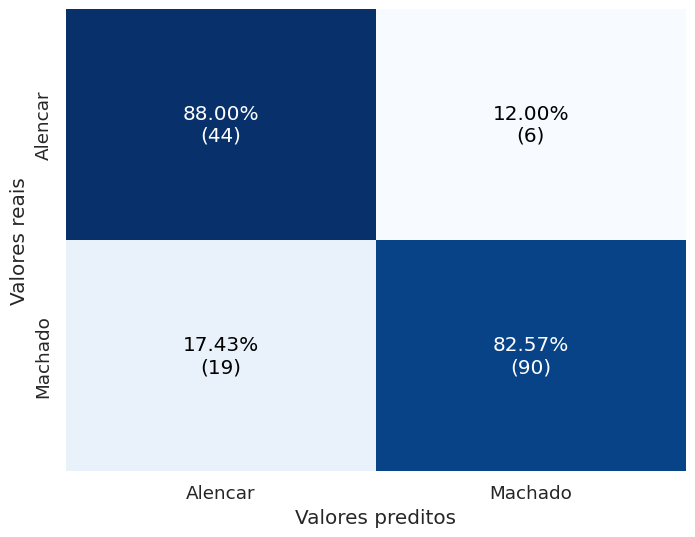

In [49]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["Alencar", "Machado"]

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1, keepdims=True)

# Configuração do gráfico
class_names = labels
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if conf_matrix_percent[i, j] > 0.7:
          color = "white"
        else:
          color="black"
        plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2%}\n({conf_matrix[i, j]})", ha="center", va="center", color=color)

plt.xlabel('Valores preditos')
plt.ylabel('Valores reais')
# plt.title('Matriz de Confusão Multiclasse')
plt.savefig('MatrizConfusao.png', dpi=300)
plt.show()

In [50]:
trainer.save_model('modeloDiferenciarAutores')

In [64]:
# Adicionando a informação da legenda no arquivo config.json

import json

# Carregar o conteúdo atual do arquivo config.json
with open('/content/modeloDiferenciarAutores/config.json', 'r') as file:
    config = json.load(file)

# Adicionar o novo texto ao dicionário
config["id2label"] =  {
    "0":"Alencar",
    "1":"Machado"
    }

# Escrever o conteúdo atualizado de volta para o arquivo config.json
with open('/content/modeloDiferenciarAutores/config.json', 'w') as file:
    json.dump(config, file, indent=4)

In [54]:
!tar -czvf "modeloDiferenciarAutores.tar.gz" "/content/modeloDiferenciarAutores"

tar: Removing leading `/' from member names
/content/modeloDiferenciarAutores/
/content/modeloDiferenciarAutores/config.json
/content/modeloDiferenciarAutores/model.safetensors
/content/modeloDiferenciarAutores/training_args.bin


In [55]:
!mv "/content/modeloDiferenciarAutores.tar.gz" "/content/drive/MyDrive/Machine Learning/TransferLearningEscritores"

In [65]:
# O tokenizer é o mesmo do modelo original pois não o alterei, mas apenas o modelo

from transformers import AutoTokenizer, AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("/content/modeloDiferenciarAutores")
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [66]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)


In [72]:
# Frase de Alencar pra fechar

pipe("""
Eu te amei desde o momento em que te vi!
Eu te amei por séculos nestes poucos dias que passamos juntos na terra.
Agora que a minha vida se conta por instantes, amo-te em cada momento por uma existência inteira.
Amo-te ao mesmo tempo com todas as afeições que se pode ter neste mundo. Vou te amar enfim por toda a eternidade.
""")

[[{'label': 'Alencar', 'score': 0.8857727646827698},
  {'label': 'Machado', 'score': 0.11422725766897202}]]